### Тематическое моделирование 

## Данные - вопросы с сайта роспотребнадзора

In [69]:
# !pip install corus

In [3]:
import requests
from bs4 import BeautifulSoup 
import time
from urllib.parse import urlparse, urljoin
from tqdm.notebook import tqdm
import pandas as pd

### Парсер

In [ ]:
## найти id каждого вопроса на страницах
page = 1
main_url = 'https://zpp.rospotrebnadzor.ru/Forum/Appeals/AjaxindexList?page={page}&searchtext=&categories=[]'

def ids_from_page(soup):
    return [i.get('href') for i  in soup.findAll('a', {'class':'appeal-title-link'})]
    
urls = []
for page in tqdm(range(1, 500), desc='Pages'):
    time.sleep(0.5)
    res = requests.get(main_url.format(page=page))  
    soup = BeautifulSoup(res.text)
    urls.extend(ids_from_page(soup))

In [ ]:
## имея id запросов достанем тексты на страницах
domain = 'https://zpp.rospotrebnadzor.ru'

def get_text_page_question(soup):
    return soup.findAll('p', {'class':'appeal-details-message'})[0].text

question = []

for url in tqdm(urls, desc='Pages'):
    time.sleep(0.5)
    res = requests.get(urljoin(domain, url))  
    soup = BeautifulSoup(res.text)
    
    question.append(get_text_page_question(soup))

In [ ]:
df = pd.DataFrame(question, columns = ['question'])

In [ ]:
df.to_csv('question_rospotreb.csv') #сохраняем данные

In [6]:
data = pd.read_csv('question_rospotreb.csv')

In [7]:
len(data)

2495

In [11]:
data.head()

,Unnamed: 0,question
0,0,31 октября 2023 г.я оформила заказ в приложени...
1,1,"Добры день, по ошибке заказал на wildberries н..."
2,2,Здравствуйте. В марте я обратилась в стоматол...
3,3,Добрый день! \r\n\r\nНедавно преодолев мужские...
4,4,Доброе утро!\r\nПолучила в подарок сертификат ...


### Предобработка


Все модели, с которыми мы будем работать далее, работают с предобработанными текстами, поэтому сперва проведем стандартную предобработку текста:

In [12]:
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from multiprocessing import Pool
from pymystem3 import Mystem

In [13]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ekaterina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
! pip install pymorphy2

/bin/bash: /home/ekaterina/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [15]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

In [16]:
words_regex = re.compile('\w+')

def find_words(text, regex = words_regex):
    tokens =  regex.findall(text.lower())
    return [w for w in tokens if w.isalpha() and len(w) >= 3]


stopwords_list = stopwords.words('russian')

# mystem = Mystem()
# def lemmatize(words, lemmer = mystem, stopwords = stopwords_list):
#     lemmas = lemmer.lemmatize(' '.join(words))
#     return [w for w in lemmas if not w in stopwords 
#             and w.isalpha()]

def lemmatize(words, lemmer = morph, stopwords = stopwords_list):
    lemmas = [lemmer.parse(w)[0].normal_form for w in words]
    return [w for w in lemmas if not w in stopwords 
            and w.isalpha()]

def preprocess(text):
    return (lemmatize(find_words(text)))

In [17]:
data.question.iloc[1]

'Добры день, по ошибке заказал на wildberries не тот товар, хотел сразу же отказаться, а такой возможности нет, нужно ждать когда товар прибудет в пункт выдачи и только тогда можно будет отказаться платно! либо если товар не доставят в течении 6 дней, то так же платно можно отказаться.  почему нельзя отказаться от товара до его отправки в ПВЗ, допустим в течение часа после оформления? Почему я должен ждать не нужны мне товар и потом платить за отказ от него и ждать возвращения денежных средств? Является ли это нарушением Закона РФ от 07.02.1992 N 2300-1 (ред. от 04.08.2023) "О защите прав потребителей статьи 16 пункта 2? Не занимается ли данная торговая площадка элементарным вымогательством, создавая своим покупателям  такие условия при которых они должны просто так отдавать свои деньги?'

In [19]:
print(preprocess(data.question.iloc[1]))

['добрый', 'день', 'ошибка', 'заказать', 'wildberries', 'товар', 'хотеть', 'сразу', 'отказаться', 'возможность', 'нужно', 'ждать', 'товар', 'прибыть', 'пункт', 'выдача', 'отказаться', 'платно', 'либо', 'товар', 'доставить', 'течение', 'день', 'платно', 'отказаться', 'почему', 'отказаться', 'товар', 'отправка', 'пвз', 'допустить', 'течение', 'час', 'оформление', 'почему', 'должный', 'ждать', 'нужный', 'товар', 'платить', 'отказ', 'ждать', 'возвращение', 'денежный', 'средство', 'являться', 'это', 'нарушение', 'закон', 'ред', 'защита', 'право', 'потребитель', 'статья', 'пункт', 'заниматься', 'дать', 'торговый', 'площадка', 'элементарный', 'вымогательство', 'создавать', 'свой', 'покупатель', 'условие', 'который', 'должный', 'просто', 'отдавать', 'свой', 'деньга']


In [20]:
preprocessed_text = list(tqdm(map(preprocess, data['question']), total=len(data)))

  0%|          | 0/2495 [00:00<?, ?it/s]

In [21]:
data['question_prep'] = preprocessed_text
data.sample(3)

,Unnamed: 0,question,question_prep
1638,1638,Прошу обязать УК Вектор провести дезинсекцию п...,"[просить, обязать, вектор, провести, дезинсекц..."
314,314,Добрый день. Озон подтвердил возврат стирально...,"[добрый, день, озон, подтвердить, возврат, сти..."
2020,2020,Здравствуйте. Мне пришло сообщение от компании...,"[здравствуйте, прийти, сообщение, компания, от..."


## Модель LDA

In [22]:
!pip install -U gensim

/bin/bash: /home/ekaterina/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     |████████████████████████████████| 26.6 MB 3.6 MB/s eta 0:00:01
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [23]:
from gensim.models import *
from gensim import corpora

Модель использует векторное представление документов, например, мешок слов (bow), поэтому сперва создадим словарь:

In [24]:
dictionary = corpora.Dictionary(data['question_prep'])

dictionary.filter_extremes(no_below = 5, no_above = 0.95, keep_n=None) # игнорируем слова, которые встречаются реже 5 раз или составляют более 0.95 словаря 
dictionary.save('rospotreb.dict')

Векторизуем документы:

In [25]:
corpus = [dictionary.doc2bow(text) for text in data['question_prep']]
corpora.MmCorpus.serialize('rospotreb.model', corpus) 

Теперь можем обучать модель:

In [26]:
%time lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=30, chunksize=50, update_every=1, passes=2)

CPU times: user 1.86 s, sys: 1.25 s, total: 3.11 s
Wall time: 1.57 s


Посмотрим на получившиеся темы:

In [29]:
lda.show_topics(num_topics=10, num_words=10, formatted=True)

[(20,
  '0.063*"день" + 0.049*"средство" + 0.035*"ответ" + 0.033*"денежный" + 0.026*"получить" + 0.025*"срок" + 0.023*"оплата" + 0.020*"поступить" + 0.020*"сумма" + 0.019*"течение"'),
 (25,
  '0.167*"очень" + 0.111*"экспертиза" + 0.111*"детский" + 0.091*"обувь" + 0.052*"температура" + 0.046*"комната" + 0.046*"группа" + 0.037*"киров" + 0.031*"материал" + 0.030*"годность"'),
 (4,
  '0.129*"оплатить" + 0.122*"сайт" + 0.057*"условие" + 0.053*"курьер" + 0.033*"спасибо" + 0.030*"осуществлять" + 0.030*"изменение" + 0.025*"иной" + 0.024*"утверждать" + 0.023*"случай"'),
 (11,
  '0.122*"услуга" + 0.082*"потребитель" + 0.062*"право" + 0.051*"закон" + 0.046*"год" + 0.041*"оператор" + 0.036*"информация" + 0.032*"защита" + 0.030*"компания" + 0.028*"подать"'),
 (5,
  '0.000*"эксплуатация" + 0.000*"повлечь" + 0.000*"ограничение" + 0.000*"продолжить" + 0.000*"применение" + 0.000*"полчаса" + 0.000*"стиральный" + 0.000*"незаконный" + 0.000*"необоснованный" + 0.000*"опломбировать"'),
 (21,
  '0.000*"повле

Посмотрим на метрики качества получившейся модели: перплексию и среднюю когерентность:

In [33]:
print(lda.log_perplexity(corpus))


-15.372088637325428


In [34]:
print('Персплексия: ', np.exp(lda.log_perplexity(corpus)))

Персплексия:  2.1085151573407054e-07


In [35]:
coherence_model_lda = CoherenceModel(model=lda, texts=data['question_prep'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.3436410915908497


Теперь можно подобрать оптимальное количество тем, опираясь на значение метрик:

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/8 [00:00<?, ?it/s]

/home/ekaterina/anaconda3/lib/python3.9/site-packages/gensim/models/ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


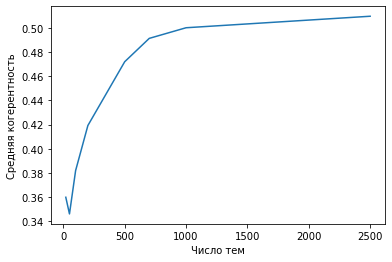

In [38]:
topics_list = [20, 50, 100, 200, 500, 700, 1000, 2500]
coherences = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=data['question_prep'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

Посмотрим динамику показателя perplexity в зависимости от количества тем

  0%|          | 0/8 [00:00<?, ?it/s]

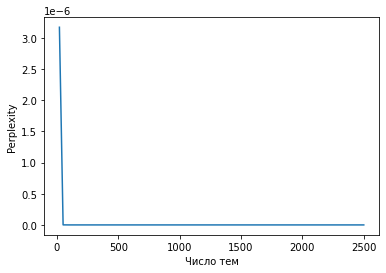

In [47]:
topics_list = [20, 50, 100, 200, 500, 700, 1000, 2500]
perplexity = []

for num in tqdm(topics_list):
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    perplexity.append(np.exp(lda.log_perplexity(corpus)))

plt.plot(topics_list, perplexity)
plt.xlabel("Число тем")
plt.ylabel("Perplexity")
plt.show()

Исходя из анализа двух метрик выбираем оптимальное количество тем 1000.

In [49]:
lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=1000, chunksize=50, update_every=1, passes=2)

In [50]:
print(lda_model.log_perplexity(corpus))

-354.8091062006668


In [51]:
print('Персплексия: ', np.exp(lda_model.log_perplexity(corpus)))

Персплексия:  8.101041336775778e-155


In [52]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['question_prep'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.49969884917234697


## Визуализация

Для наглядности посмотрим визуализацию для модели LDA из 10 тем

In [64]:
lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=10, chunksize=50, update_every=1, passes=2)

In [66]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/ekaterina/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1335 samples in 0.001s...
[t-SNE] Computed neighbors for 1335 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1335
[t-SNE] Computed conditional probabilities for sample 1335 / 1335
[t-SNE] Mean sigma: 0.103155
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.305626
[t-SNE] KL divergence after 1000 iterations: 0.821507


/home/ekaterina/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


Loading BokehJS ...

/home/ekaterina/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/home/ekaterina/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


/home/ekaterina/anaconda3/lib/python3.9/site-packages/bokeh/io/notebook.py:487: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  publish_display_data(data, metadata, source, transient=transient, **kwargs)


In [67]:
print('Персплексия: ', np.exp(lda_model.log_perplexity(corpus)))

Персплексия:  0.0006970234405116232


In [68]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=data['question_prep'], dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Средняя когерентность: ', coherence_lda)

Средняя когерентность:  0.39878512189799087


На 10 темах модель неплохо проводит кластеризацию данных. На графике TSNE темы хорошо разделены.